In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA
from pycytominer.cyto_utils import infer_cp_features
import sys
sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import data_selection as ds
from utils import eval
import statistics

In [2]:
# random features
features = [f"feature_{i}" for i in range(20)]
meta_features = ["Metadata_broad_sample", 'Metadata_moa']
df = pd.DataFrame(np.random.randint(-50,50,size=(200, 20)), columns=features)
df['Metadata_broad_sample'] = range(df.shape[0])

In [3]:
MOAs = ['MOA_0',
 'MOA_1',
 'MOA_2',
 'MOA_3',
 'MOA_4',
 'MOA_0',
 'MOA_1',
 'MOA_2',
 'MOA_3',
 'MOA_4',
 'MOA_5',
 'MOA_6',
 'MOA_7',
 'MOA_8',
 'MOA_9',
'MOA_10',
 'MOA_11',
 'MOA_12',
 'MOA_13',
 'MOA_14']

In [4]:
df['Metadata_moa'] = np.random.choice(MOAs, df.shape[0])
df['Metadata_moa'].value_counts()

MOA_3     26
MOA_0     17
MOA_1     17
MOA_4     17
MOA_2     16
MOA_11    15
MOA_13    13
MOA_12    13
MOA_6     12
MOA_9     10
MOA_7     10
MOA_5      9
MOA_14     9
MOA_10     8
MOA_8      8
Name: Metadata_moa, dtype: int64

In [19]:
N = 100
df = pd.DataFrame(np.random.randint(-20,20,size=(200, 20)), columns=features)

MOA_list = np.random.choice(MOAs, df.shape[0])
pd.DataFrame(MOA_list).value_counts()

MOA_2     25
MOA_4     22
MOA_0     21
MOA_1     18
MOA_3     17
MOA_10    12
MOA_12    12
MOA_7     12
MOA_5     11
MOA_6     11
MOA_11    10
MOA_9      9
MOA_13     8
MOA_8      7
MOA_14     5
dtype: int64

In [20]:
ls = []
ls_pre =[]
for n in range(N):
    df = pd.DataFrame(np.random.randint(-20,20,size=(200, 20)), columns=features)
    df['Metadata_broad_sample'] = range(df.shape[0])
    df['Metadata_moa'] = MOA_list
    e = eval.evaluation(df, features=features, meta_features=meta_features)
    all_enr = e.eval(df, operation = 'enrichment')
    # all_prec = e.eval(df, operation = 'precision_recall')
    ls.append(all_enr)
    # ls_pre.append(all_prec)

res_enr = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

In [21]:
moa_in = ['MOA_0',
 'MOA_1',
 'MOA_2',
 'MOA_3',
 'MOA_4']

In [22]:
df_in = df[df.Metadata_moa.isin(moa_in)]
df_out = df[~df.Metadata_moa.isin(moa_in)]

In [23]:
ls = []
for n in range(N):
    e = eval.evaluation(df_in, features=features, meta_features=meta_features)
    enr = e.eval(df_in, operation = 'enrichment')
    ls.append(enr)

res_enr_in = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

In [24]:
ls = []
for n in range(N):
    e = eval.evaluation(df_out, features=features, meta_features=meta_features)
    enr = e.eval(df_out, operation = 'enrichment')
    # all_prec = eval.prec_mean(e.eval(df_out, operation = 'precision_recall')[["k","precision",'recall']])
    ls.append(enr)

# res_pre_out = pd.concat([ls[n] for n in range(N)]).groupby(by="k", as_index=False).mean().sort_values(by="k", ascending=True)
res_enr_out = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

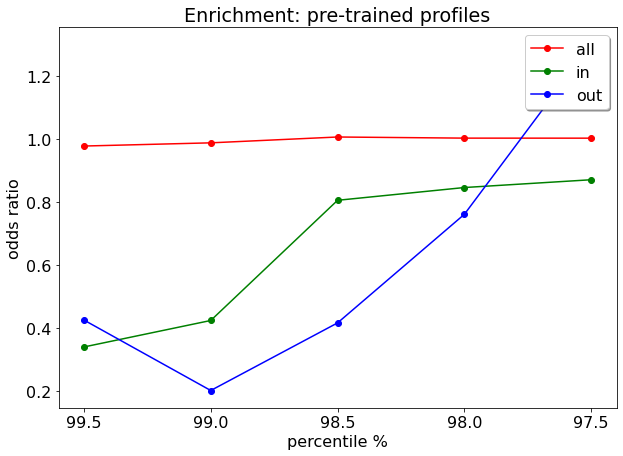

In [25]:
eval.plotting.enrichment('Enrichment: pre-trained profiles', index1=res_enr, label_1="all", index2=res_enr_in, label_2="in", index3=res_enr_out, label_3="out")

# precision


In [12]:
res_pre = pd.concat([ls_pre[n] for n in range(N)])
res_pre_group = res_pre.groupby(by=["k", "Metadata_broad_sample"], as_index=False).mean()

In [13]:
res_pre_group["Metadata_broad_sample"] = res_pre_group["Metadata_broad_sample"].astype(int)
res_pre_group = pd.merge(res_pre_group, df[meta_features], how='left', on=["Metadata_broad_sample"])

In [14]:
re_pre_in = res_pre_group[res_pre_group.Metadata_moa.isin(moa_in)].groupby(by=["k"], as_index=False).mean()
re_pre_out = res_pre_group[~res_pre_group.Metadata_moa.isin(moa_in)].groupby(by=["k"], as_index=False).mean()
re_pre_all = res_pre_group.groupby(by=["k"], as_index=False).mean()

In [15]:
re_pre_out

,k,Metadata_broad_sample,precision,recall
0,5.0,99.30303,0.048323,0.024853
1,10.0,99.30303,0.049091,0.050260
2,15.0,99.30303,0.048916,0.075153
3,20.0,99.30303,0.048798,0.100219
4,25.0,99.30303,0.049164,0.125885
5,30.0,99.30303,0.049407,0.151672
6,40.0,99.30303,0.049394,0.201719
7,50.0,99.30303,0.049228,0.251453


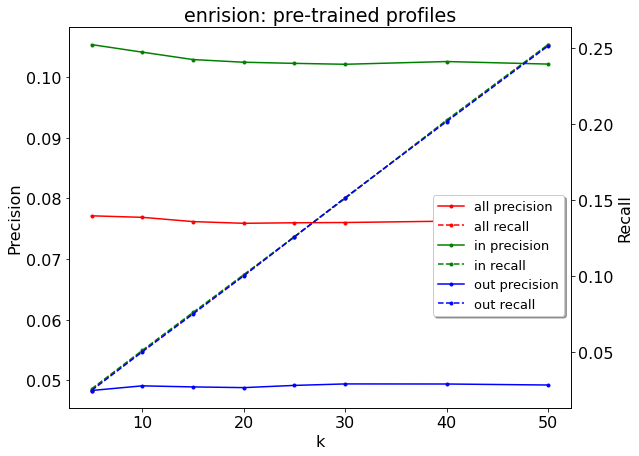

In [16]:
eval.plotting.prec_recall('enrision: pre-trained profiles', fontsize= 13, index1=re_pre_all, label_1="all", index2=re_pre_in, label_2="in", index3=re_pre_out, label_3="out")

In [17]:
re_pre_all



,k,Metadata_broad_sample,precision,recall
0,5.0,99.5,0.077120,0.025384
1,10.0,99.5,0.076870,0.050737
2,15.0,99.5,0.076167,0.075688
3,20.0,99.5,0.075885,0.100625
4,25.0,99.5,0.075972,0.125965
5,30.0,99.5,0.076017,0.151414
6,40.0,99.5,0.076237,0.202212
7,50.0,99.5,0.075944,0.251899


In [43]:
# hitk
N = 50
ls_hit = []
for n in range(N):
    df = pd.DataFrame(np.random.randint(-20,20,size=(200, 20)), columns=features)
    df['Metadata_broad_sample'] = range(df.shape[0])
    df['Metadata_moa'] = MOA_list
    # df_in = df[df.Metadata_moa.isin(moa_in)]
    # df_out = df[~df.Metadata_moa.isin(moa_in)]
    e = eval.evaluation(df, features=features, meta_features=meta_features)
    all_hit = eval.hitk_prep(e.eval(df, operation = 'hitk'))
    ls_hit.append(all_hit)
res_all_hit = pd.DataFrame(ls_hit).transpose().mean(axis=1)
# res_enr = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

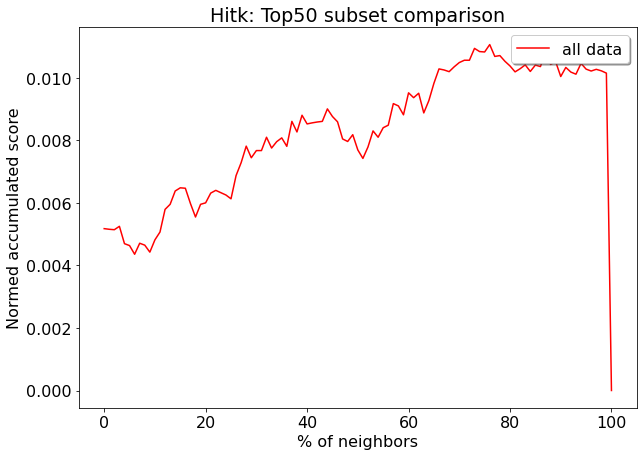

In [44]:
eval.plotting.hitk('Hitk: Top50 subset comparison',  index1=res_all_hit, label_1="all data", ) #index2=df812_in_hit, label_2="in-Top50", index3=df812_out_hit, label_3="out-Top50"

In [ ]:
ls = []
for n in range(N):
    e = eval.evaluation(df_in, features=features, meta_features=meta_features)
    enr = e.eval(df_in, operation = 'enrichment')
    ls.append(enr)

res_enr_in = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

In [ ]:
ls = []
for n in range(N):
    e = eval.evaluation(df_out, features=features, meta_features=meta_features)
    enr = e.eval(df_out, operation = 'enrichment')
    # all_prec = eval.prec_mean(e.eval(df_out, operation = 'precision_recall')[["k","precision",'recall']])
    ls.append(enr)

# res_pre_out = pd.concat([ls[n] for n in range(N)]).groupby(by="k", as_index=False).mean().sort_values(by="k", ascending=True)
res_enr_out = pd.concat([ls[n] for n in range(N)]).groupby(by="enrichment_percentile", as_index=False).mean().sort_values(by="enrichment_percentile", ascending=False)

In [ ]:
eval.plotting.enrichment('Enrichment: pre-trained profiles', index1=res_enr, label_1="all", index2=res_enr_in, label_2="in", index3=res_enr_out, label_3="out")